# <center> xG Calculator for Rocket League <center>

## <center> Defining and Training the xG Model <center>

### Importing Packages:

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_accuracy

### Model Construction:

In [3]:
class xG_LSTM(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, output_dim=1, latent_dim=64, num_layers=3):
        super(xG_LSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        self.lstm_layer = nn.LSTM(self.input_dim, self.hidden_dim, 
                                  self.num_layers, bidirectional=False, batch_first=True)
        
        self.fc_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.latent_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.latent_dim, self.output_dim)
        )

    def forward(self, x, hidden_states=None):
        if hidden_states is None:
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
            hidden_states = (h_0, c_0)

        x, hidden_states = self.lstm_layer(x)
        x = self.fc_layer(x[:, -1, :])

        return x.squeeze(-1)

### Dataset creation:

In [4]:
dataset = torch.load('/Users/marcomaluf/Desktop/Unfinished Projects/New RL/datasets/LSTM1_preprocessing/dataset.pt')
len(dataset)

/var/folders/11/n8zkztqx4gz05487nfq4vl740000gn/T/ipykernel_54837/2128852830.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('/Users/marcomaluf/Deskt

7722

In [5]:
train_pkg_size = 6177
train_set_size = 4632
val_set_size = train_pkg_size - train_set_size
test_set_size = 7722-train_pkg_size

train_pkg, test_set = random_split(dataset, [train_pkg_size, test_set_size])
train_set, val_set = random_split(train_pkg, [train_set_size, val_set_size])

train_dataloader = DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_set, batch_size=512, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False)

### Setting hyperparameters and training/validation loops:

In [6]:
device = 'mps' if torch.backends.mps.is_built() else 'cpu'
model = xG_LSTM(hidden_dim=256).to(device)
LOSS_FN = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 500
PATIENCE = 10
PATIENCE_COUNTER = 0
MIN_DELTA = 0.00001
BEST_VAL_LOSS = float('inf')

def train_one_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    for batch_x, batch_y in tqdm(dataloader):
        x, y = batch_x.to(device), batch_y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss = loss.item()
    return train_loss

def evaluate(model, dataloader, loss_fn):
    model.eval()
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader):
            x, y = batch_x.to(device), batch_y.to(device)
            logits = model(x)
            val_loss += loss_fn(logits, y).item() * x.size()[0]
            val_accuracy += binary_accuracy(logits.squeeze(), y.squeeze())

    val_loss /= len(dataloader.dataset)
    val_accuracy /= len(dataloader)

    return val_loss, val_accuracy   

### Training the model:

In [7]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}:')
    train_loss = train_one_epoch(model, train_dataloader, LOSS_FN, OPTIMIZER)
    train_losses.append(train_loss)

    validation_loss, validation_acc = evaluate(model, val_dataloader, LOSS_FN)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_acc)

    print(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}")

    if validation_loss + MIN_DELTA < BEST_VAL_LOSS:
        BEST_VAL_LOSS = validation_loss
        PATIENCE_COUNTER = 0
    else:
        PATIENCE_COUNTER += 1
        if PATIENCE_COUNTER >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1:


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Train Loss: 0.6767, Validation Loss: 0.6655, Validation Accuracy: 0.5076
Epoch 2:


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Train Loss: 0.5242, Validation Loss: 0.5071, Validation Accuracy: 0.6902
Epoch 3:


100%|██████████| 4/4 [00:00<00:00, 13.52it/s]


Train Loss: 0.4286, Validation Loss: 0.3527, Validation Accuracy: 0.8882
Epoch 4:


100%|██████████| 4/4 [00:00<00:00, 15.32it/s]


Train Loss: 0.2974, Validation Loss: 0.2645, Validation Accuracy: 0.8887
Epoch 5:


100%|██████████| 4/4 [00:00<00:00, 11.68it/s]


Train Loss: 0.2026, Validation Loss: 0.1806, Validation Accuracy: 0.9536
Epoch 6:


100%|██████████| 4/4 [00:00<00:00, 10.41it/s]


Train Loss: 0.1551, Validation Loss: 0.1644, Validation Accuracy: 0.9141
Epoch 7:


100%|██████████| 4/4 [00:00<00:00,  9.11it/s]


Train Loss: 0.1229, Validation Loss: 0.0984, Validation Accuracy: 0.9717
Epoch 8:


100%|██████████| 4/4 [00:00<00:00, 10.97it/s]


Train Loss: 0.1080, Validation Loss: 0.0955, Validation Accuracy: 0.9400
Epoch 9:


100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


Train Loss: 0.0939, Validation Loss: 0.0955, Validation Accuracy: 0.9419
Epoch 10:


100%|██████████| 4/4 [00:00<00:00, 10.98it/s]


Train Loss: 0.0841, Validation Loss: 0.0862, Validation Accuracy: 0.9795
Epoch 11:


100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Train Loss: 0.0459, Validation Loss: 0.0710, Validation Accuracy: 0.9810
Epoch 12:


100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Train Loss: 0.0716, Validation Loss: 0.0661, Validation Accuracy: 0.9551
Epoch 13:


100%|██████████| 4/4 [00:00<00:00, 14.23it/s]


Train Loss: 0.0405, Validation Loss: 0.0518, Validation Accuracy: 0.9854
Epoch 14:


100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


Train Loss: 0.0234, Validation Loss: 0.0488, Validation Accuracy: 0.9858
Epoch 15:


100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Train Loss: 0.0296, Validation Loss: 0.0485, Validation Accuracy: 0.9868
Epoch 16:


100%|██████████| 4/4 [00:00<00:00, 13.01it/s]


Train Loss: 0.0305, Validation Loss: 0.0564, Validation Accuracy: 0.9595
Epoch 17:


100%|██████████| 4/4 [00:00<00:00, 13.71it/s]


Train Loss: 0.0239, Validation Loss: 0.0726, Validation Accuracy: 0.9824
Epoch 18:


100%|██████████| 4/4 [00:00<00:00, 13.08it/s]


Train Loss: 0.0365, Validation Loss: 0.0593, Validation Accuracy: 0.9854
Epoch 19:


100%|██████████| 4/4 [00:00<00:00, 13.85it/s]


Train Loss: 0.0429, Validation Loss: 0.0475, Validation Accuracy: 0.9902
Epoch 20:


100%|██████████| 4/4 [00:00<00:00, 14.67it/s]


Train Loss: 0.0505, Validation Loss: 0.0488, Validation Accuracy: 0.9873
Epoch 21:


100%|██████████| 4/4 [00:00<00:00, 13.54it/s]


Train Loss: 0.0324, Validation Loss: 0.0419, Validation Accuracy: 0.9883
Epoch 22:


100%|██████████| 4/4 [00:00<00:00, 16.80it/s]


Train Loss: 0.0600, Validation Loss: 0.0430, Validation Accuracy: 0.9878
Epoch 23:


100%|██████████| 4/4 [00:00<00:00, 16.83it/s]


Train Loss: 0.0265, Validation Loss: 0.0411, Validation Accuracy: 0.9629
Epoch 24:


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]


Train Loss: 0.0349, Validation Loss: 0.0450, Validation Accuracy: 0.9620
Epoch 25:


100%|██████████| 4/4 [00:00<00:00, 15.51it/s]


Train Loss: 0.0235, Validation Loss: 0.0430, Validation Accuracy: 0.9893
Epoch 26:


100%|██████████| 4/4 [00:00<00:00, 14.59it/s]


Train Loss: 0.0165, Validation Loss: 0.0391, Validation Accuracy: 0.9907
Epoch 27:


100%|██████████| 4/4 [00:00<00:00, 14.09it/s]


Train Loss: 0.0292, Validation Loss: 0.0530, Validation Accuracy: 0.9858
Epoch 28:


100%|██████████| 4/4 [00:00<00:00, 11.92it/s]


Train Loss: 0.0454, Validation Loss: 0.0359, Validation Accuracy: 0.9912
Epoch 29:


100%|██████████| 4/4 [00:00<00:00, 10.38it/s]


Train Loss: 0.0227, Validation Loss: 0.0338, Validation Accuracy: 0.9917
Epoch 30:


100%|██████████| 4/4 [00:00<00:00, 13.23it/s]


Train Loss: 0.0227, Validation Loss: 0.0445, Validation Accuracy: 0.9893
Epoch 31:


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Train Loss: 0.0392, Validation Loss: 0.0320, Validation Accuracy: 0.9946
Epoch 32:


100%|██████████| 4/4 [00:00<00:00, 13.76it/s]


Train Loss: 0.0170, Validation Loss: 0.0347, Validation Accuracy: 0.9932
Epoch 33:


100%|██████████| 4/4 [00:00<00:00, 13.82it/s]


Train Loss: 0.0165, Validation Loss: 0.0373, Validation Accuracy: 0.9912
Epoch 34:


100%|██████████| 4/4 [00:00<00:00, 14.26it/s]


Train Loss: 0.0360, Validation Loss: 0.0425, Validation Accuracy: 0.9927
Epoch 35:


100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


Train Loss: 0.0273, Validation Loss: 0.0301, Validation Accuracy: 0.9951
Epoch 36:


100%|██████████| 4/4 [00:00<00:00, 15.84it/s]


Train Loss: 0.0224, Validation Loss: 0.0321, Validation Accuracy: 0.9937
Epoch 37:


100%|██████████| 4/4 [00:00<00:00, 14.22it/s]


Train Loss: 0.0192, Validation Loss: 0.0339, Validation Accuracy: 0.9902
Epoch 38:


100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Train Loss: 0.0104, Validation Loss: 0.0353, Validation Accuracy: 0.9927
Epoch 39:


100%|██████████| 4/4 [00:00<00:00, 13.70it/s]


Train Loss: 0.0222, Validation Loss: 0.0417, Validation Accuracy: 0.9888
Epoch 40:


100%|██████████| 4/4 [00:00<00:00, 13.39it/s]


Train Loss: 0.0274, Validation Loss: 0.0267, Validation Accuracy: 0.9956
Epoch 41:


100%|██████████| 4/4 [00:00<00:00, 12.75it/s]


Train Loss: 0.0067, Validation Loss: 0.0293, Validation Accuracy: 0.9946
Epoch 42:


100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Train Loss: 0.0218, Validation Loss: 0.0338, Validation Accuracy: 0.9956
Epoch 43:


100%|██████████| 4/4 [00:00<00:00, 15.96it/s]


Train Loss: 0.0173, Validation Loss: 0.0306, Validation Accuracy: 0.9951
Epoch 44:


100%|██████████| 4/4 [00:00<00:00, 13.34it/s]


Train Loss: 0.0065, Validation Loss: 0.0314, Validation Accuracy: 0.9673
Epoch 45:


100%|██████████| 4/4 [00:00<00:00, 13.78it/s]


Train Loss: 0.0162, Validation Loss: 0.0323, Validation Accuracy: 0.9946
Epoch 46:


100%|██████████| 4/4 [00:00<00:00, 16.76it/s]


Train Loss: 0.0229, Validation Loss: 0.0360, Validation Accuracy: 0.9932
Epoch 47:


100%|██████████| 4/4 [00:00<00:00, 14.54it/s]


Train Loss: 0.0072, Validation Loss: 0.0488, Validation Accuracy: 0.9932
Epoch 48:


100%|██████████| 4/4 [00:00<00:00, 13.75it/s]


Train Loss: 0.0149, Validation Loss: 0.0327, Validation Accuracy: 0.9932
Epoch 49:


100%|██████████| 4/4 [00:00<00:00, 16.86it/s]


Train Loss: 0.0100, Validation Loss: 0.0371, Validation Accuracy: 0.9932
Epoch 50:


100%|██████████| 4/4 [00:00<00:00, 17.43it/s]

Train Loss: 0.0073, Validation Loss: 0.0366, Validation Accuracy: 0.9654
Early stopping triggered.


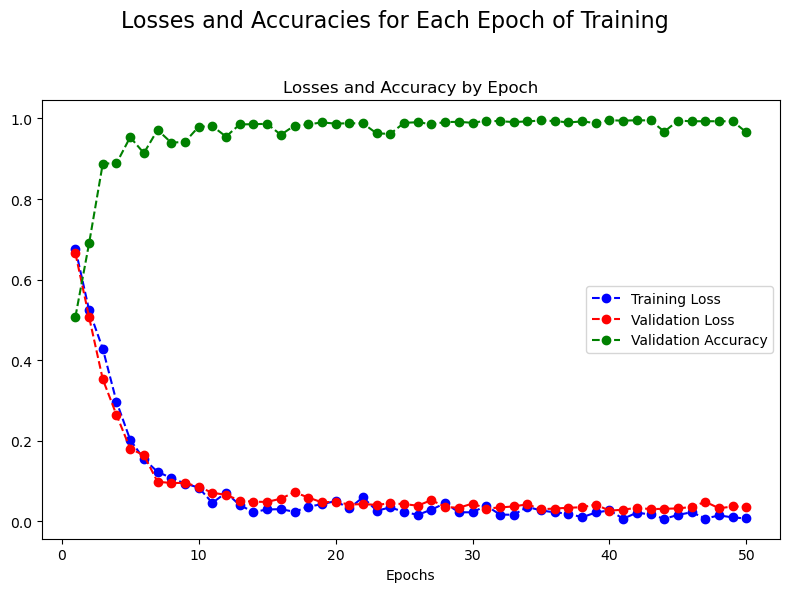

In [9]:
epochs = [i for i in range(1,51)]
val_accuracies = [a.cpu() for a in val_accuracies]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(epochs, train_losses, 'o--b', label='Training Loss')
ax.plot(epochs, val_losses, 'o--r', label='Validation Loss')
ax.plot(epochs, val_accuracies, 'o--g', label='Validation Accuracy')
ax.set_title('Losses and Accuracy by Epoch')
ax.set_xlabel('Epochs')
ax.legend()


plt.suptitle('Losses and Accuracies for Each Epoch of Training', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
test_loss, test_accuracy = evaluate(model, test_dataloader, LOSS_FN)
print(f'Test Loss: {test_loss} | Test Accuracy: {test_accuracy}')

100%|██████████| 7/7 [00:00<00:00,  7.68it/s]

Test Loss: 0.03866859000320015 | Test Accuracy: 0.9877232313156128


python(54910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


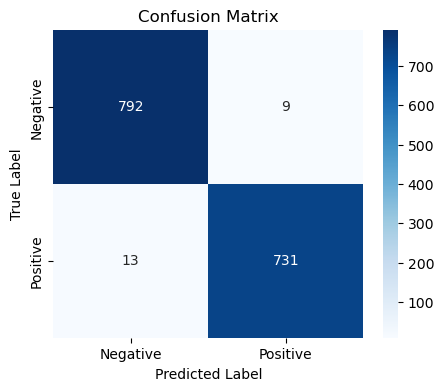

array([[792,   9],
       [ 13, 731]])

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_confusion_matrix(model, dataloader, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)  # Get raw logits
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs >= threshold).int()  # Convert probabilities to 0 or 1
            all_preds.extend(preds.cpu().numpy().flatten())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy().flatten())  # Store true labels

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm

# Call function with your test dataloader
evaluate_confusion_matrix(model, test_dataloader)


## Different model

In [12]:
model3 = xG_LSTM(hidden_dim=256, latent_dim=256).to(device)
LOSS_FN = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.Adam(model3.parameters(), lr=0.001)
EPOCHS = 500
PATIENCE = 10
PATIENCE_COUNTER = 0
MIN_DELTA = 0.00001
BEST_VAL_LOSS = float('inf')

train_losses3 = []
val_losses3 = []
val_accuracies3 = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}:')
    train_loss = train_one_epoch(model3, train_dataloader, LOSS_FN, OPTIMIZER)
    train_losses3.append(train_loss)

    validation_loss, validation_acc = evaluate(model3, val_dataloader, LOSS_FN)
    val_losses3.append(validation_loss)
    val_accuracies3.append(validation_acc)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}")

    if validation_loss + MIN_DELTA < BEST_VAL_LOSS:
        BEST_VAL_LOSS = validation_loss
        PATIENCE_COUNTER = 0
    else:
        PATIENCE_COUNTER += 1
        if PATIENCE_COUNTER >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1:


100%|██████████| 4/4 [00:00<00:00, 13.19it/s]


Train Loss: 0.6873, Validation Loss: 0.6754, Validation Accuracy: 0.5895
Epoch 2:


100%|██████████| 4/4 [00:00<00:00, 16.65it/s]


Train Loss: 0.5201, Validation Loss: 0.5145, Validation Accuracy: 0.5617
Epoch 3:


100%|██████████| 4/4 [00:00<00:00, 14.07it/s]


Train Loss: 0.3199, Validation Loss: 0.3071, Validation Accuracy: 0.7854
Epoch 4:


100%|██████████| 4/4 [00:00<00:00, 15.37it/s]


Train Loss: 0.2413, Validation Loss: 0.2408, Validation Accuracy: 0.9000
Epoch 5:


100%|██████████| 4/4 [00:00<00:00, 17.46it/s]


Train Loss: 0.1640, Validation Loss: 0.1677, Validation Accuracy: 0.9288
Epoch 6:


100%|██████████| 4/4 [00:00<00:00, 15.07it/s]


Train Loss: 0.1428, Validation Loss: 0.1271, Validation Accuracy: 0.9658
Epoch 7:


100%|██████████| 4/4 [00:00<00:00, 16.12it/s]


Train Loss: 0.1398, Validation Loss: 0.0903, Validation Accuracy: 0.9775
Epoch 8:


100%|██████████| 4/4 [00:00<00:00, 14.16it/s]


Train Loss: 0.0865, Validation Loss: 0.0957, Validation Accuracy: 0.9683
Epoch 9:


100%|██████████| 4/4 [00:00<00:00, 16.98it/s]


Train Loss: 0.0640, Validation Loss: 0.0741, Validation Accuracy: 0.9790
Epoch 10:


100%|██████████| 4/4 [00:00<00:00, 17.77it/s]


Train Loss: 0.0567, Validation Loss: 0.0676, Validation Accuracy: 0.9824
Epoch 11:


100%|██████████| 4/4 [00:00<00:00, 17.64it/s]


Train Loss: 0.0789, Validation Loss: 0.0626, Validation Accuracy: 0.9819
Epoch 12:


100%|██████████| 4/4 [00:00<00:00, 17.33it/s]


Train Loss: 0.0442, Validation Loss: 0.0533, Validation Accuracy: 0.9844
Epoch 13:


100%|██████████| 4/4 [00:00<00:00, 14.64it/s]


Train Loss: 0.0452, Validation Loss: 0.0528, Validation Accuracy: 0.9839
Epoch 14:


100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


Train Loss: 0.0865, Validation Loss: 0.0560, Validation Accuracy: 0.9605
Epoch 15:


100%|██████████| 4/4 [00:00<00:00, 16.57it/s]


Train Loss: 0.0748, Validation Loss: 0.0436, Validation Accuracy: 0.9893
Epoch 16:


100%|██████████| 4/4 [00:00<00:00, 14.73it/s]


Train Loss: 0.0468, Validation Loss: 0.0609, Validation Accuracy: 0.9834
Epoch 17:


100%|██████████| 4/4 [00:00<00:00, 16.92it/s]


Train Loss: 0.0838, Validation Loss: 0.0449, Validation Accuracy: 0.9863
Epoch 18:


100%|██████████| 4/4 [00:00<00:00, 14.87it/s]


Train Loss: 0.0541, Validation Loss: 0.0446, Validation Accuracy: 0.9878
Epoch 19:


100%|██████████| 4/4 [00:00<00:00, 16.66it/s]


Train Loss: 0.0255, Validation Loss: 0.0416, Validation Accuracy: 0.9625
Epoch 20:


100%|██████████| 4/4 [00:00<00:00, 16.81it/s]


Train Loss: 0.0182, Validation Loss: 0.0470, Validation Accuracy: 0.9888
Epoch 21:


100%|██████████| 4/4 [00:00<00:00, 17.26it/s]


Train Loss: 0.0364, Validation Loss: 0.0404, Validation Accuracy: 0.9629
Epoch 22:


100%|██████████| 4/4 [00:00<00:00, 14.36it/s]


Train Loss: 0.0239, Validation Loss: 0.0381, Validation Accuracy: 0.9912
Epoch 23:


100%|██████████| 4/4 [00:00<00:00, 16.55it/s]


Train Loss: 0.0271, Validation Loss: 0.0376, Validation Accuracy: 0.9932
Epoch 24:


100%|██████████| 4/4 [00:00<00:00, 17.12it/s]


Train Loss: 0.0666, Validation Loss: 0.0357, Validation Accuracy: 0.9932
Epoch 25:


100%|██████████| 4/4 [00:00<00:00, 17.54it/s]


Train Loss: 0.0283, Validation Loss: 0.0374, Validation Accuracy: 0.9912
Epoch 26:


100%|██████████| 4/4 [00:00<00:00, 14.22it/s]


Train Loss: 0.0337, Validation Loss: 0.0349, Validation Accuracy: 0.9922
Epoch 27:


100%|██████████| 4/4 [00:00<00:00, 16.72it/s]


Train Loss: 0.0299, Validation Loss: 0.0373, Validation Accuracy: 0.9946
Epoch 28:


100%|██████████| 4/4 [00:00<00:00, 17.75it/s]


Train Loss: 0.0216, Validation Loss: 0.0397, Validation Accuracy: 0.9902
Epoch 29:


100%|██████████| 4/4 [00:00<00:00, 17.47it/s]


Train Loss: 0.0299, Validation Loss: 0.0322, Validation Accuracy: 0.9941
Epoch 30:


100%|██████████| 4/4 [00:00<00:00, 16.70it/s]


Train Loss: 0.0431, Validation Loss: 0.0326, Validation Accuracy: 0.9927
Epoch 31:


100%|██████████| 4/4 [00:00<00:00, 14.42it/s]


Train Loss: 0.0196, Validation Loss: 0.0370, Validation Accuracy: 0.9912
Epoch 32:


100%|██████████| 4/4 [00:00<00:00, 16.87it/s]


Train Loss: 0.0175, Validation Loss: 0.0345, Validation Accuracy: 0.9932
Epoch 33:


100%|██████████| 4/4 [00:00<00:00, 17.82it/s]


Train Loss: 0.0080, Validation Loss: 0.0318, Validation Accuracy: 0.9946
Epoch 34:


100%|██████████| 4/4 [00:00<00:00, 16.75it/s]


Train Loss: 0.0212, Validation Loss: 0.0343, Validation Accuracy: 0.9941
Epoch 35:


100%|██████████| 4/4 [00:00<00:00, 17.49it/s]


Train Loss: 0.0384, Validation Loss: 0.0325, Validation Accuracy: 0.9683
Epoch 36:


100%|██████████| 4/4 [00:00<00:00, 17.73it/s]


Train Loss: 0.0338, Validation Loss: 0.0338, Validation Accuracy: 0.9941
Epoch 37:


100%|██████████| 4/4 [00:00<00:00, 13.59it/s]


Train Loss: 0.0331, Validation Loss: 0.0400, Validation Accuracy: 0.9922
Epoch 38:


100%|██████████| 4/4 [00:00<00:00, 16.20it/s]


Train Loss: 0.0177, Validation Loss: 0.0428, Validation Accuracy: 0.9902
Epoch 39:


100%|██████████| 4/4 [00:00<00:00, 13.64it/s]


Train Loss: 0.0273, Validation Loss: 0.0297, Validation Accuracy: 0.9951
Epoch 40:


100%|██████████| 4/4 [00:00<00:00, 14.49it/s]


Train Loss: 0.0208, Validation Loss: 0.0337, Validation Accuracy: 0.9932
Epoch 41:


100%|██████████| 4/4 [00:00<00:00, 13.84it/s]


Train Loss: 0.0128, Validation Loss: 0.0339, Validation Accuracy: 0.9922
Epoch 42:


100%|██████████| 4/4 [00:00<00:00, 13.94it/s]


Train Loss: 0.0038, Validation Loss: 0.0389, Validation Accuracy: 0.9946
Epoch 43:


100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


Train Loss: 0.0187, Validation Loss: 0.0377, Validation Accuracy: 0.9937
Epoch 44:


100%|██████████| 4/4 [00:00<00:00, 13.77it/s]


Train Loss: 0.0134, Validation Loss: 0.0335, Validation Accuracy: 0.9946
Epoch 45:


100%|██████████| 4/4 [00:00<00:00, 16.08it/s]


Train Loss: 0.0183, Validation Loss: 0.0398, Validation Accuracy: 0.9937
Epoch 46:


100%|██████████| 4/4 [00:00<00:00, 15.90it/s]


Train Loss: 0.0104, Validation Loss: 0.0321, Validation Accuracy: 0.9951
Epoch 47:


100%|██████████| 4/4 [00:00<00:00, 16.64it/s]


Train Loss: 0.0105, Validation Loss: 0.0371, Validation Accuracy: 0.9932
Epoch 48:


100%|██████████| 4/4 [00:00<00:00, 12.07it/s]


Train Loss: 0.0202, Validation Loss: 0.0421, Validation Accuracy: 0.9946
Epoch 49:


100%|██████████| 4/4 [00:00<00:00, 13.29it/s]

Train Loss: 0.0051, Validation Loss: 0.0439, Validation Accuracy: 0.9946
Early stopping triggered.


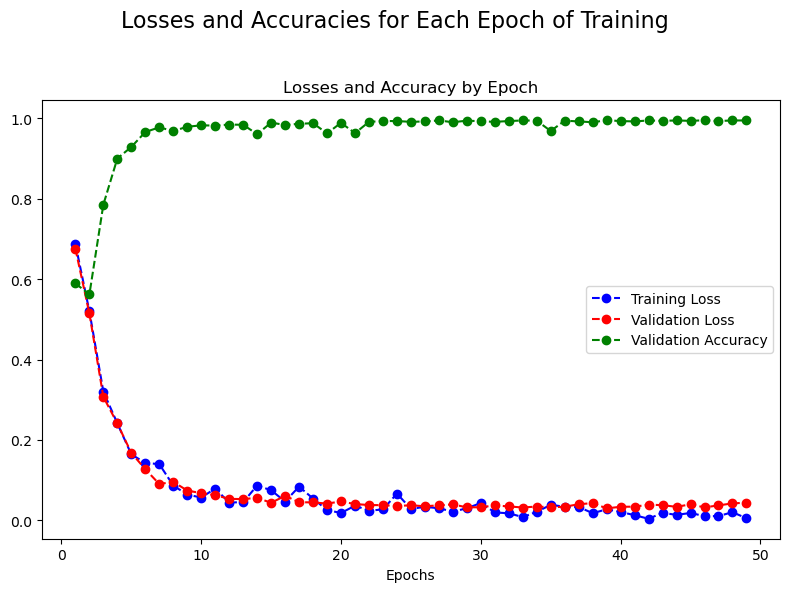

In [13]:
epochs = [i for i in range(1,50)]
val_accuracies3 = [a.cpu() for a in val_accuracies3]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(epochs, train_losses3, 'o--b', label='Training Loss')
ax.plot(epochs, val_losses3, 'o--r', label='Validation Loss')
ax.plot(epochs, val_accuracies3, 'o--g', label='Validation Accuracy')
ax.set_title('Losses and Accuracy by Epoch')
ax.set_xlabel('Epochs')
ax.legend()


plt.suptitle('Losses and Accuracies for Each Epoch of Training', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
test_loss, test_accuracy = evaluate(model3, test_dataloader, LOSS_FN)
print(f'Test Loss: {test_loss} | Test Accuracy: {test_accuracy}')

100%|██████████| 7/7 [00:00<00:00, 22.62it/s]

Test Loss: 0.03408273502318597 | Test Accuracy: 0.9938616156578064


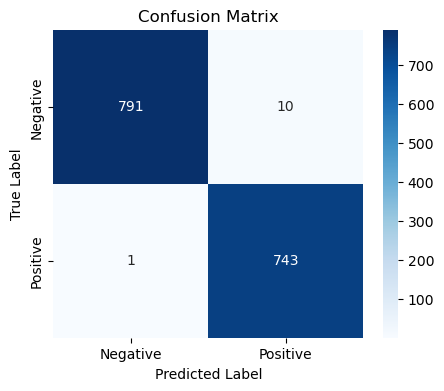

array([[791,  10],
       [  1, 743]])

In [15]:
evaluate_confusion_matrix(model3, test_dataloader)

In [16]:
model_simple = xG_LSTM(hidden_dim=64, latent_dim=32).to(device)
LOSS_FN = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.Adam(model_simple.parameters(), lr=0.001)
EPOCHS = 500
PATIENCE = 10
PATIENCE_COUNTER = 0
MIN_DELTA = 0.00001
BEST_VAL_LOSS = float('inf')

train_losses4 = []
val_losses4 = []
val_accuracies4 = []

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}:')
    train_loss = train_one_epoch(model_simple, train_dataloader, LOSS_FN, OPTIMIZER)
    train_losses4.append(train_loss)

    validation_loss, validation_acc = evaluate(model_simple, val_dataloader, LOSS_FN)
    val_losses4.append(validation_loss)
    val_accuracies4.append(validation_acc)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}")

    if validation_loss + MIN_DELTA < BEST_VAL_LOSS:
        BEST_VAL_LOSS = validation_loss
        PATIENCE_COUNTER = 0
    else:
        PATIENCE_COUNTER += 1
        if PATIENCE_COUNTER >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1:


100%|██████████| 4/4 [00:00<00:00, 19.61it/s]


Train Loss: 0.6937, Validation Loss: 0.6930, Validation Accuracy: 0.5076
Epoch 2:


100%|██████████| 4/4 [00:00<00:00, 70.08it/s]


Train Loss: 0.6908, Validation Loss: 0.6890, Validation Accuracy: 0.5076
Epoch 3:


100%|██████████| 4/4 [00:00<00:00, 72.87it/s]


Train Loss: 0.6828, Validation Loss: 0.6783, Validation Accuracy: 0.5622
Epoch 4:


100%|██████████| 4/4 [00:00<00:00, 74.51it/s]


Train Loss: 0.6507, Validation Loss: 0.6433, Validation Accuracy: 0.5622
Epoch 5:


100%|██████████| 4/4 [00:00<00:00, 75.73it/s]


Train Loss: 0.5949, Validation Loss: 0.5748, Validation Accuracy: 0.5349
Epoch 6:


100%|██████████| 4/4 [00:00<00:00, 71.87it/s]


Train Loss: 0.5228, Validation Loss: 0.5042, Validation Accuracy: 0.8145
Epoch 7:


100%|██████████| 4/4 [00:00<00:00, 75.52it/s]


Train Loss: 0.4322, Validation Loss: 0.4103, Validation Accuracy: 0.8691
Epoch 8:


100%|██████████| 4/4 [00:00<00:00, 75.18it/s]


Train Loss: 0.3512, Validation Loss: 0.3487, Validation Accuracy: 0.8516
Epoch 9:


100%|██████████| 4/4 [00:00<00:00, 71.09it/s]


Train Loss: 0.2914, Validation Loss: 0.2633, Validation Accuracy: 0.9321
Epoch 10:


100%|██████████| 4/4 [00:00<00:00, 76.02it/s]


Train Loss: 0.2143, Validation Loss: 0.2099, Validation Accuracy: 0.9448
Epoch 11:


100%|██████████| 4/4 [00:00<00:00, 73.63it/s]


Train Loss: 0.1646, Validation Loss: 0.1652, Validation Accuracy: 0.9526
Epoch 12:


100%|██████████| 4/4 [00:00<00:00, 74.30it/s]


Train Loss: 0.1235, Validation Loss: 0.1271, Validation Accuracy: 0.9380
Epoch 13:


100%|██████████| 4/4 [00:00<00:00, 75.56it/s]


Train Loss: 0.0896, Validation Loss: 0.1099, Validation Accuracy: 0.9648
Epoch 14:


100%|██████████| 4/4 [00:00<00:00, 65.00it/s]


Train Loss: 0.0818, Validation Loss: 0.0824, Validation Accuracy: 0.9483
Epoch 15:


100%|██████████| 4/4 [00:00<00:00, 72.71it/s]


Train Loss: 0.0815, Validation Loss: 0.0748, Validation Accuracy: 0.9215
Epoch 16:


100%|██████████| 4/4 [00:00<00:00, 77.73it/s]


Train Loss: 0.0584, Validation Loss: 0.1043, Validation Accuracy: 0.9604
Epoch 17:


100%|██████████| 4/4 [00:00<00:00, 67.16it/s]


Train Loss: 0.0475, Validation Loss: 0.0688, Validation Accuracy: 0.9819
Epoch 18:


100%|██████████| 4/4 [00:00<00:00, 70.76it/s]


Train Loss: 0.0623, Validation Loss: 0.0755, Validation Accuracy: 0.9829
Epoch 19:


100%|██████████| 4/4 [00:00<00:00, 60.23it/s]


Train Loss: 0.0714, Validation Loss: 0.0660, Validation Accuracy: 0.9810
Epoch 20:


100%|██████████| 4/4 [00:00<00:00, 64.23it/s]


Train Loss: 0.0761, Validation Loss: 0.0611, Validation Accuracy: 0.9839
Epoch 21:


100%|██████████| 4/4 [00:00<00:00, 65.79it/s]


Train Loss: 0.0658, Validation Loss: 0.0584, Validation Accuracy: 0.9829
Epoch 22:


100%|██████████| 4/4 [00:00<00:00, 62.90it/s]


Train Loss: 0.0410, Validation Loss: 0.0560, Validation Accuracy: 0.9844
Epoch 23:


100%|██████████| 4/4 [00:00<00:00, 76.64it/s]


Train Loss: 0.0611, Validation Loss: 0.0570, Validation Accuracy: 0.9863
Epoch 24:


100%|██████████| 4/4 [00:00<00:00, 74.82it/s]


Train Loss: 0.0428, Validation Loss: 0.0520, Validation Accuracy: 0.9849
Epoch 25:


100%|██████████| 4/4 [00:00<00:00, 77.26it/s]


Train Loss: 0.0535, Validation Loss: 0.0496, Validation Accuracy: 0.9863
Epoch 26:


100%|██████████| 4/4 [00:00<00:00, 73.87it/s]


Train Loss: 0.0289, Validation Loss: 0.0473, Validation Accuracy: 0.9858
Epoch 27:


100%|██████████| 4/4 [00:00<00:00, 75.85it/s]


Train Loss: 0.0407, Validation Loss: 0.0461, Validation Accuracy: 0.9873
Epoch 28:


100%|██████████| 4/4 [00:00<00:00, 71.17it/s]


Train Loss: 0.0479, Validation Loss: 0.0473, Validation Accuracy: 0.9888
Epoch 29:


100%|██████████| 4/4 [00:00<00:00, 60.16it/s]


Train Loss: 0.0236, Validation Loss: 0.0437, Validation Accuracy: 0.9878
Epoch 30:


100%|██████████| 4/4 [00:00<00:00, 73.70it/s]


Train Loss: 0.0405, Validation Loss: 0.0431, Validation Accuracy: 0.9893
Epoch 31:


100%|██████████| 4/4 [00:00<00:00, 75.83it/s]


Train Loss: 0.0481, Validation Loss: 0.0414, Validation Accuracy: 0.9902
Epoch 32:


100%|██████████| 4/4 [00:00<00:00, 70.62it/s]


Train Loss: 0.0406, Validation Loss: 0.0468, Validation Accuracy: 0.9600
Epoch 33:


100%|██████████| 4/4 [00:00<00:00, 45.58it/s]


Train Loss: 0.0306, Validation Loss: 0.0459, Validation Accuracy: 0.9893
Epoch 34:


100%|██████████| 4/4 [00:00<00:00, 60.62it/s]


Train Loss: 0.0357, Validation Loss: 0.0409, Validation Accuracy: 0.9893
Epoch 35:


100%|██████████| 4/4 [00:00<00:00, 73.66it/s]


Train Loss: 0.0376, Validation Loss: 0.0411, Validation Accuracy: 0.9897
Epoch 36:


100%|██████████| 4/4 [00:00<00:00, 77.25it/s]


Train Loss: 0.0134, Validation Loss: 0.0442, Validation Accuracy: 0.9897
Epoch 37:


100%|██████████| 4/4 [00:00<00:00, 72.72it/s]


Train Loss: 0.0271, Validation Loss: 0.0389, Validation Accuracy: 0.9893
Epoch 38:


100%|██████████| 4/4 [00:00<00:00, 61.16it/s]


Train Loss: 0.0382, Validation Loss: 0.0402, Validation Accuracy: 0.9615
Epoch 39:


100%|██████████| 4/4 [00:00<00:00, 73.38it/s]


Train Loss: 0.0484, Validation Loss: 0.0367, Validation Accuracy: 0.9927
Epoch 40:


100%|██████████| 4/4 [00:00<00:00, 78.07it/s]


Train Loss: 0.0492, Validation Loss: 0.0360, Validation Accuracy: 0.9937
Epoch 41:


100%|██████████| 4/4 [00:00<00:00, 62.67it/s]


Train Loss: 0.0227, Validation Loss: 0.0368, Validation Accuracy: 0.9937
Epoch 42:


100%|██████████| 4/4 [00:00<00:00, 60.43it/s]


Train Loss: 0.0224, Validation Loss: 0.0572, Validation Accuracy: 0.9814
Epoch 43:


100%|██████████| 4/4 [00:00<00:00, 55.64it/s]


Train Loss: 0.0191, Validation Loss: 0.0756, Validation Accuracy: 0.9766
Epoch 44:


100%|██████████| 4/4 [00:00<00:00, 77.56it/s]


Train Loss: 0.0449, Validation Loss: 0.0379, Validation Accuracy: 0.9917
Epoch 45:


100%|██████████| 4/4 [00:00<00:00, 62.37it/s]


Train Loss: 0.0157, Validation Loss: 0.0580, Validation Accuracy: 0.9868
Epoch 46:


100%|██████████| 4/4 [00:00<00:00, 61.96it/s]


Train Loss: 0.0241, Validation Loss: 0.0529, Validation Accuracy: 0.9849
Epoch 47:


100%|██████████| 4/4 [00:00<00:00, 48.93it/s]


Train Loss: 0.0310, Validation Loss: 0.0428, Validation Accuracy: 0.9917
Epoch 48:


100%|██████████| 4/4 [00:00<00:00, 74.45it/s]


Train Loss: 0.0204, Validation Loss: 0.0367, Validation Accuracy: 0.9917
Epoch 49:


100%|██████████| 4/4 [00:00<00:00, 73.85it/s]


Train Loss: 0.0235, Validation Loss: 0.0396, Validation Accuracy: 0.9888
Epoch 50:


100%|██████████| 4/4 [00:00<00:00, 63.27it/s]

Train Loss: 0.0187, Validation Loss: 0.0409, Validation Accuracy: 0.9912
Early stopping triggered.


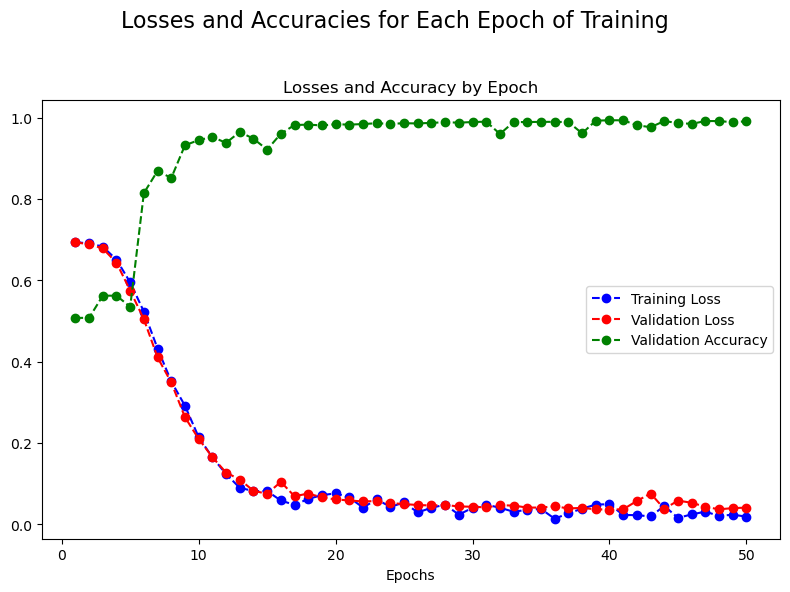

In [17]:
epochs = [i for i in range(1,51)]
val_accuracies4 = [a.cpu() for a in val_accuracies4]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(epochs, train_losses4, 'o--b', label='Training Loss')
ax.plot(epochs, val_losses4, 'o--r', label='Validation Loss')
ax.plot(epochs, val_accuracies4, 'o--g', label='Validation Accuracy')
ax.set_title('Losses and Accuracy by Epoch')
ax.set_xlabel('Epochs')
ax.legend()


plt.suptitle('Losses and Accuracies for Each Epoch of Training', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
test_loss, test_accuracy = evaluate(model_simple, test_dataloader, LOSS_FN)
print(f'Test Loss: {test_loss} | Test Accuracy: {test_accuracy}')

100%|██████████| 7/7 [00:00<00:00,  8.33it/s]

Test Loss: 0.0497226193630887 | Test Accuracy: 0.9860491156578064


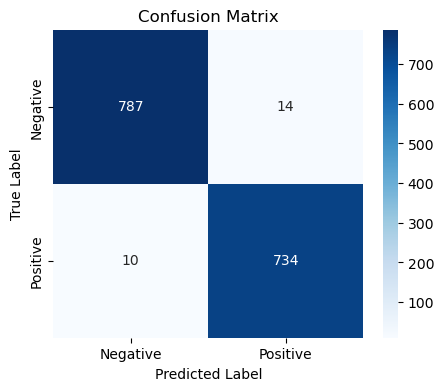

array([[787,  14],
       [ 10, 734]])

In [20]:
evaluate_confusion_matrix(model_simple, test_dataloader)

## FINAL CHOICE:

Model 3!!!!
- hidden_dim = 256
- latent_dim = 256

In [21]:
torch.save(model3.state_dict(), '/Users/marcomaluf/Desktop/Unfinished Projects/New RL/models/best_LSTM_state_dict.pth')